In [10]:
import argparse
from argparse import Namespace
import matplotlib.pyplot as plt
import json
import os
import numpy
import e57
import cv2

from PCDprocessing.pcd2img import project_PCD2ERP
from PCDprocessing.img2pcd import project_ERP_to_PCD
from segmentations.segmentation import segmentation_img

In [16]:
args = argparse.Namespace(
    model='BEiT_ADE',
    pcd_path='./../daeyoung/CustomPCD/(Test)Aisle_origin.e57',
    img_width=1800,
    img_height=900,
    )
args2 = argparse.Namespace(
    model='BEiT_ADE',
    pcd_path='./../daeyoung/CustomPCD/(Test)Aisle_cleaned.e57',
    img_width=1800,
    img_height=900,
    )
# args = load_config_as_args('../config.json')
print(args.pcd_path)

./../daeyoung/CustomPCD/(Test)Aisle_origin.e57


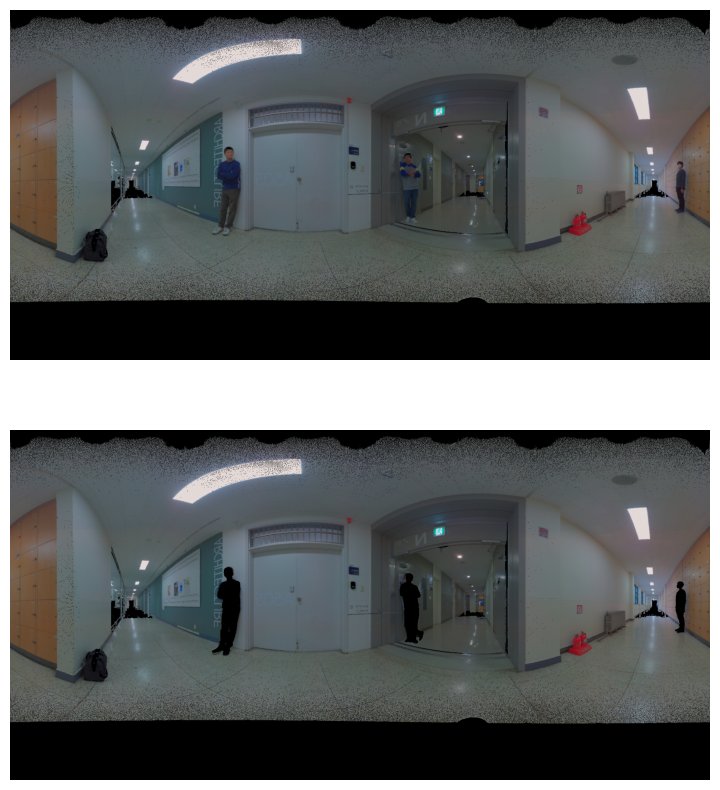

In [19]:
# pcd = e57.read_points(args.pcd_path)
prj_im = project_PCD2ERP(args)
cv2.imwrite("./../daeyoung/CustomPCD/imgs/aisle_origin.png", prj_im)

# pcd2 = e57.read_points(args2.pcd_path)
prj_im2 = project_PCD2ERP(args2)
cv2.imwrite("./../daeyoung/CustomPCD/imgs/aisle_cleaned.png", prj_im2)

plt.figure(figsize=(10,10))
plt.subplot(211)
plt.imshow(prj_im)
plt.axis('off')

plt.subplot(212)
plt.imshow(prj_im2)
plt.axis('off')

plt.show()

True

Loads checkpoint by http backend from path: https://download.openmmlab.com/mmsegmentation/v0.5/beit/upernet_beit-large_fp16_8x1_640x640_160k_ade20k/upernet_beit-large_fp16_8x1_640x640_160k_ade20k-8fc0dd5d.pth


/usr/local/lib/python3.9/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
/usr/local/lib/python3.9/dist-packages/mmseg/models/builder.py:36: UserWarning: ``build_loss`` would be deprecated soon, please use ``mmseg.registry.MODELS.build()`` 
  warnings.warn('``build_loss`` would be deprecated soon, please use '
/usr/local/lib/python3.9/dist-packages/mmseg/models/losses/cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


01/21 03:53:23 - mmengine - WARNING - Failed to search registry with scope "mmseg" in the "function" registry tree. As a workaround, the current "function" registry in "mmengine" is used to build instance. This may cause unexpected failure when running the built modules. Please check whether "mmseg" is a correct scope, or whether the registry is initialized.


Output()

/usr/local/lib/python3.9/dist-packages/mmengine/visualization/visualizer.py:196: UserWarning: Failed to add <class 'mmengine.visualization.vis_backend.LocalVisBackend'>, please provide the `save_dir` argument.
  warnings.warn(f'Failed to add {vis_backend.__class__}, '


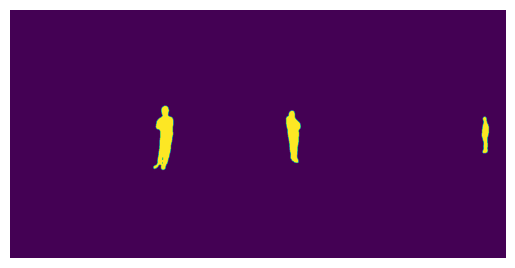

In [8]:
def load_config_as_args(json_path):
    """Load configuration from a JSON file and return it as an argparse.Namespace object."""
    if not os.path.exists(json_path):
        raise FileNotFoundError(f"Configuration file not found: {json_path}")
    with open(json_path, 'r') as file:
        config = json.load(file)

    # Convert dictionary to Namespace
    args = Namespace(**config)
    # args = parser.parse_args()
    return args
args = load_config_as_args("config.json")

## Segmentation mask generation
human_mask = segmentation_img(prj_im, args)
plt.imshow(human_mask)
plt.axis('off')
plt.show()

# Test on PCD again

In [4]:
reprojected_pcd = project_ERP_to_PCD(args,prj_im)

In [5]:
import e57
pcd = e57.read_points(args.pcd_path)

In [ ]:
import numpy as np

## XYZ 차이 디버깅
xyz_diff = np.linalg.norm(pcd.points - reprojected_pcd[:,:3], axis=1)
print("XYZ Difference Stats:")
print(f"Mean Difference: {np.mean(xyz_diff)}")
print(f"Max Difference: {np.max(xyz_diff)}")

XYZ Difference Stats:
Mean Difference: 0.0
Max Difference: 0.0


In [19]:
## RGB 차이 디버깅
rgb_diff = np.abs(pcd.color*255 - reprojected_pcd[:,3:])
print("RGB Difference Stats:")
print(f"Mean Difference: {np.mean(rgb_diff)}")
print(f"Max Difference: {np.max(rgb_diff)}")

RGB Difference Stats:
Mean Difference: 5.636071402825401
Max Difference: 255.0


In [20]:
def project_direct_PCD2ERP(args, pcd):
    rgb_pcd = np.concatenate((pcd[:, :3], np.array(pcd[:, 3:],dtype=np.uint8())),axis=1)
    prj_img = np.zeros((args.img_height, args.img_width, 3), dtype=np.uint8)

    # 포인트 위치와 RGB 값 분리
    xyz = rgb_pcd[:, :3]
    rgb = rgb_pcd[:, 3:].astype(np.uint8)

    # XYZ 좌표를 구형 좌표계 (방위각, 고도각)로 변환
    x, y, z = xyz[:, 0], xyz[:, 1], xyz[:, 2]

    # 방위각 (theta)와 고도각 (phi) 계산
    theta = np.arctan2(y, x)  # 방위각
    phi = np.arcsin(z / np.linalg.norm(xyz, axis=1))  # 고도각

    # 방위각과 고도각을 이미지의 픽셀 좌표로 변환
    u = ((theta + np.pi) / (2 * np.pi) * args.img_width).astype(int)  # [0, width] 범위로 매핑
    v = ((1 - (phi + (np.pi / 2)) / np.pi) * args.img_height).astype(int)  # [0, height] 범위로 매핑

    # 이미지 경계 값으로 클리핑
    u = np.clip(u, 0, args.img_width - 1)
    v = np.clip(v, 0, args.img_height - 1)

    # 각 픽셀에 RGB 값을 매핑
    prj_img[v, u] = rgb
    # for i in range(len(rgb_pcd)):
    #     prj_img[v[i], u[i]] = rgb[i]
    return prj_img

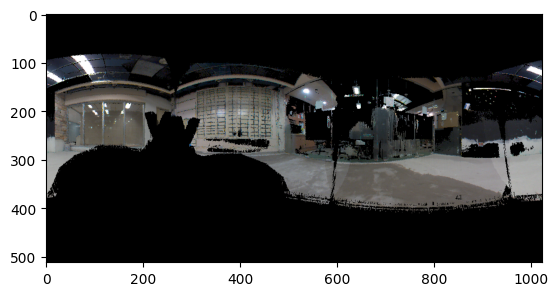

In [21]:
prj_im2 = project_direct_PCD2ERP(args, reprojected_pcd)
plt.imshow(prj_im2)
plt.show()

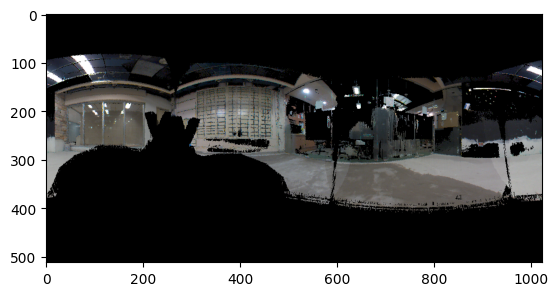

In [22]:
plt.imshow(prj_im)
plt.show()